In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

from ntk import get_ntk_n
from linear_region_counter import Linear_Region_Collector

import scipy.stats as stats
import matplotlib.pyplot as plt

import tqdm

# custom
from custom_models import get_cell_based_tiny_net

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
# parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=0, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

13443
Namespace(arch_nas_dataset='../../NAS-Bench-201-v1_1-096897.pth', channel=16, config_path='../../configs/nas-benchmark/algos/RANDOM.config', data_path='../../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=13443, save_dir='./results/tmp', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=0)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 13443
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 1
CUDA_VISIBLE_DEVICES : 0


In [4]:
def kaiming_normal_fanin_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def kaiming_normal_fanout_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def init_model(model, method='kaiming_norm_fanin'):
    if method == 'kaiming_norm_fanin':
        model.apply(kaiming_normal_fanin_init)
    elif method == 'kaiming_norm_fanout':
        model.apply(kaiming_normal_fanout_init)
    return model

####### original
def pca_eig_diag(xloader, network, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    with torch.no_grad():
        feat_list = []
        for i, (inputs, targets) in enumerate(xloader):
            if num_batch > 0 and i >= num_batch: break

            inputs = inputs.cuda(device=device, non_blocking=True)
            network.zero_grad()
            inputs_ = torch.randn_like(inputs)
            _ = network(inputs_)
            feat = network.last_feature_map.detach().clone()
            b,c,h,w = feat.size()
            feat_list.append(feat.permute(0,2,3,1).contiguous().view(b*h*w,c))

        feat = torch.cat(feat_list, dim=0)
        m = feat.mean(dim=0, keepdim=True)
        feat = feat - m
        sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
        u, s, v = torch.svd(sigma)
        prob_s = s / s.sum()
        score = (-prob_s)*torch.log(prob_s+1e-8)
        score = score.sum()
            
        torch.cuda.empty_cache()
    
    return score.item()

def fwrd_norm_preserving(xloader, network):
    device = torch.cuda.current_device()
    network.train()
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(xloader):
            inputs = inputs.cuda(device=device, non_blocking=True)
            network.zero_grad()
            inputs_ = torch.randn_like(inputs)
            _ = network(inputs_)
            break

        cell_features = network.cell_features
        scores = []
        for i in range(1, len(cell_features)):
            f_out = cell_features[i]
            f_in = cell_features[i-1]
            
            if (f_out.size() == f_in.size()) and (torch.all(f_in == f_out)):
                scores.append(-np.inf)
            else:
                s = f_out.norm(dim=(1)).mean() / (f_in.norm(dim=(1)).mean()+1e-6)
                scores.append((-torch.abs(s-1)).item())
        score = np.mean(scores)
        
        torch.cuda.empty_cache()
    
    return score.item()

def grad_vanish(xloader, network, criterion, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    for i, (inputs, targets) in enumerate(xloader):
        if num_batch > 0 and i >= num_batch: break

        inputs = inputs.cuda(device=device, non_blocking=True)
        targets = targets.cuda(device=device, non_blocking=True)
        
        network.zero_grad()
#         inputs_ = inputs
        inputs_ = torch.randn_like(inputs)
        _, logits = network(inputs_)


################### std
#         cell_features = network.cell_features
    
#         loss = criterion(logits, targets)
#         loss.backward()

#         scores = []
#         for i in reversed(range(1, len(cell_features))):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]

#             if f_out.size() == f_in.size():
#                 if torch.all(f_in.grad == f_out.grad) or torch.all(f_in == f_out):
#                     scores.append(-1)
#             else:
#                 s = f_in.grad.view(-1).std() / (f_out.grad.view(-1).std()+1e-6)
# #                 scores.append(s.item())
#                 scores.append(-((1-s.item())**2))
#         score = np.mean(scores)
################### weight grad
#         loss = criterion(logits, targets)
#         loss.backward()

# #         g = torch.randn_like(network.last_feature_map)
# #         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
# #         network.last_feature_map.backward(g)
#         w_g = network.stem[0].weight.grad
#         c_out,c_in,kh,kw = w_g.size()
#         score = w_g.view(c_out,-1).norm(dim=1).mean()
################### using a CE loss
#         loss = criterion(logits, targets)
#         loss.backward()
#         cell_features = network.cell_features

#         scores = []
#         for i in reversed(range(1, len(cell_features))):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]
        
#             s = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
# #             s = f_in.grad.norm() / (f_out.grad.norm()+1e-6)
# #             print(s)
# #             scores.append(s.item())
#             scores.append(-np.abs(1-s.item()))
#         score = np.mean(scores)  
################### # feature vector norm 0.42
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm(dim=(1))
#         score = s_grad_norm.mean()
################### traverse all cell features
#         cell_features = network.cell_features
#         f_last = cell_features[-1]
#         g = torch.randn_like(f_last)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         f_last.backward(g)
        
#         scores = []
#         for i in reversed(range(1, len(cell_features))):
# #         for i in reversed(range(1, 5)):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]
        
#             s = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
# #             scores.append(s.item())
#             scores.append(-np.abs(1-s.item()))
#         score = np.mean(scores)
################### channel norm
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm(dim=(2,3),keepdim=True)+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm(dim=(2,3))
#         score = s_grad_norm.mean()
################### entire norm
#         g = torch.randn_like(network.last_feature_map)
#         g = g / (g.norm()+1e-6)
#         network.last_feature_map.backward(g)
        
#         s_grad_norm = network.first_feature_map.grad.norm()
#         score = s_grad_norm
################### # batch-wise norm
#         g = torch.randn_like(network.last_feature_map)
#         b,c,h,w = g.size()
#         g = g.view(b, -1)
#         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
#         g = g.view(b,c,h,w)
#         network.last_feature_map.backward(g)
        
#         g = network.first_feature_map.grad
#         b,c,h,w = g.size()
#         g = g.view(b, -1)
#         s_grad_norm = g.norm(dim=(1))
#         score = s_grad_norm.mean()
# ################### traverse cell features in a stage
#         cell_features = network.cell_features
    
#         loss = criterion(logits, targets)
#         loss.backward()
        
# #         f_last = cell_features[-1]
# #         g = torch.randn_like(f_last)
# #         g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
# #         f_last.backward(g)
        
#         scores = []
#         for i in reversed(range(1, len(cell_features))):
#             f_out = cell_features[i]
#             f_in = cell_features[i-1]
            
#             if (f_out.size() == f_in.size()) and torch.all(f_in.grad == f_out.grad):
#                 scores.append(-np.inf)
#             else:
#                 s1 = f_in.grad.norm(dim=(1)).mean() / (f_out.grad.norm(dim=(1)).mean()+1e-6)
#                 scores.append((-torch.abs(s1-1)).item())
#         score = np.mean(scores)
################### traverse cell features in a stage
        cell_features = network.cell_features
    
#         loss = criterion(logits, targets)
#         loss.backward()
        
        f_last = cell_features[-1]
        g = torch.ones_like(f_last)
        g = g / (g.norm(dim=(1),keepdim=True)+1e-6)
        f_last.backward(g)
        
        scores = []
        for i in reversed(range(1, len(cell_features))):
            f_out = cell_features[i]
            f_in = cell_features[i-1]
            
            if (f_out.size() == f_in.size()) and torch.all(f_in.grad == f_out.grad):
                scores.append(-np.inf)
            else:
#                 s1 = f_in.grad.max(dim=(1))[0].mean() / (f_out.grad.max(dim=(1))[0].mean()+1e-6)
                s1 = f_in.grad.abs().max() / (f_out.grad.abs().max()+1e-6)
#                 s1 = f_in.grad.std() / (f_out.grad.std()+1e-6)
#                 s1 = f_in.grad.norm() / (f_out.grad.norm()+1e-6)
                scores.append((-torch.abs(s1-1)).item())
        score = np.mean(scores)
###################
    torch.cuda.empty_cache()
    
    return score.item()

def search_find_best(xloader, network, criterion, lrc_model, n_samples):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    
    network.train()
    archs, pca_scores, fnorm_scores, grad_scores, ntk_scores, lr_scores = [], [], [], [], [], []
    
    for i in tqdm.tqdm(range(n_samples)):
        # random sampling
        arch = network.random_genotype(True)
    
        pca_score_tmp, grad_score_tmp, fnorm_score_tmp, ntk_score_tmp, lr_score_tmp = [], [], [], [], []
        pca_time, grad_time, fnorm_time, ntk_time, lr_time = [], [], [], [], []
        pca_mem, grad_mem, fnorm_mem, ntk_mem, lr_mem = [], [], [], [], []
        
        for _ in range(1):
            init_model(network)
            
            # pca score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = pca_eig_diag(xloader, network)
            pca_score_tmp.append(score)
            end.record()
            torch.cuda.synchronize()
            pca_time.append(start.elapsed_time(end))
            pca_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
                                                  
            # fnorm score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = fwrd_norm_preserving(xloader, network)
            fnorm_score_tmp.append(score)
            end.record()
            torch.cuda.synchronize()
            fnorm_time.append(start.elapsed_time(end))
            fnorm_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            
            # grad score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = grad_vanish(xloader, network, criterion)
            grad_score_tmp.append(score)
            end.record()
            torch.cuda.synchronize()
            grad_time.append(start.elapsed_time(end))
            grad_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            
            # ntk score        
            start.record()
            torch.cuda.reset_peak_memory_stats()
            score = -get_ntk_n(xloader, [network], recalbn=0, train_mode=True, num_batch=1)[0]
            end.record()
            torch.cuda.synchronize()
            ntk_time.append(start.elapsed_time(end))
            ntk_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()
            ntk_score_tmp.append(score)
            
            # lr score
            start.record()
            torch.cuda.reset_peak_memory_stats()
            lrc_model.reinit(models=[network], seed=xargs.rand_seed)
            score = lrc_model.forward_batch_sample()
            end.record()
            torch.cuda.synchronize()
            lr_time.append(start.elapsed_time(end))
            lr_mem.append(torch.cuda.max_memory_reserved())
            lr_score_tmp.append(score)
            lrc_model.clear()
        
        archs.append(arch)
        pca_scores.append(np.mean(pca_score_tmp))
        fnorm_scores.append(np.mean(fnorm_score_tmp))
        grad_scores.append(np.mean(grad_score_tmp))
        ntk_scores.append(np.mean(ntk_score_tmp))
        lr_scores.append(np.mean(lr_score_tmp))
        
        print(arch)
        print("-----------------")
        print("PCA: {:.5f} ms".format(np.mean(pca_time)))
        print("FNorm: {:.5f} ms".format(np.mean(fnorm_time)))
        print("Grad: {:.5f} ms".format(np.mean(grad_time)))
        print("NTK: {:.5f} ms".format(np.mean(ntk_time)))
        print("LR: {:.5f} ms".format(np.mean(lr_time)))
        print("-----------------")
        print("PCA: {:.5f} GB".format(np.mean(pca_mem)/1e9))
        print("FNorm: {:.5f} GB".format(np.mean(fnorm_mem)/1e9))
        print("Grad: {:.5f} GB".format(np.mean(grad_mem)/1e9))
        print("NTK: {:.5f} GB".format(np.mean(ntk_mem)/1e9))
        print("LR: {:.5f} GB".format(np.mean(lr_mem)/1e9))
        print("-----------------\n")
    
    pca_scores = np.nan_to_num(np.array(pca_scores), nan=-np.inf)
    fnorm_scores = np.nan_to_num(np.array(fnorm_scores), nan=-np.inf)
    grad_scores = np.nan_to_num(np.array(grad_scores), nan=-np.inf)
    ntk_scores = np.nan_to_num(np.array(ntk_scores), nan=-np.inf)
    lr_scores = np.nan_to_num(np.array(lr_scores), nan=-np.inf)
        
    return archs, pca_scores, fnorm_scores, grad_scores, ntk_scores, lr_scores

# Main

In [5]:
## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))


## model
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

_, _, criterion = get_optim_scheduler(search_model.parameters(), config)
criterion = criterion.cuda()

if "api" not in vars():
    if xargs.arch_nas_dataset is None:
        api = None
    else:
        api = API(xargs.arch_nas_dataset)
    logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
# network = torch.nn.DataParallel(search_model).cuda()
network = search_model.cuda()

## LRC
if "lrc_model" not in vars():
    lrc_model = Linear_Region_Collector(input_size=(333, 3, 3, 3), sample_batch=3, dataset=xargs.dataset, data_path=xargs.data_path, seed=xargs.rand_seed)


## misc
if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=250, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
try to create the NAS-Bench-201 api from ../../NAS-Bench-201-v1_1-096897.pth
[2023-02-07 06:23:56] create API = NASBench201API(15625/15625 architectures, file=NAS-Bench-201-v1_1-096897.pth) done
Files already downloaded and verified
Files already downloaded and verified
=> do not find the last-info file : re

In [6]:
n_samples = 100

archs, pca_scores, fnorm_scores, grad_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, criterion, lrc_model, n_samples)

  1%|          | 1/100 [00:01<02:09,  1.31s/it]

Structure(4 nodes with |none~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|none~1|none~2|)
-----------------
PCA: 651.01880 ms
FNorm: 32.02234 ms
Grad: 46.27248 ms
NTK: 559.95160 ms
LR: 13.80819 ms
-----------------
PCA: 0.08598 GB
FNorm: 0.08598 GB
Grad: 0.14051 GB
NTK: 0.23278 GB
LR: 0.19084 GB
-----------------



  2%|▏         | 2/100 [00:03<02:19,  1.43s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|)
-----------------
PCA: 47.17459 ms
FNorm: 38.73018 ms
Grad: 68.52259 ms
NTK: 1473.72961 ms
LR: 54.32691 ms
-----------------
PCA: 0.20762 GB
FNorm: 0.32925 GB
Grad: 0.60398 GB
NTK: 0.99615 GB
LR: 0.84306 GB
-----------------



  3%|▎         | 3/100 [00:04<02:26,  1.51s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|skip_connect~2|)
-----------------
PCA: 46.91209 ms
FNorm: 41.00586 ms
Grad: 68.53069 ms
NTK: 1475.81299 ms
LR: 69.66791 ms
-----------------
PCA: 0.20972 GB
FNorm: 0.33135 GB
Grad: 0.60398 GB
NTK: 1.25619 GB
LR: 0.95420 GB
-----------------



  4%|▍         | 4/100 [00:07<03:07,  1.95s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|none~2|)
-----------------
PCA: 1205.81482 ms
FNorm: 39.11309 ms
Grad: 68.65146 ms
NTK: 1531.89246 ms
LR: 129.52657 ms
-----------------
PCA: 0.21181 GB
FNorm: 0.33345 GB
Grad: 0.60817 GB
NTK: 1.39880 GB
LR: 1.10310 GB
-----------------



  5%|▌         | 5/100 [00:09<03:09,  1.99s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|skip_connect~2|)
-----------------
PCA: 96.39111 ms
FNorm: 80.98294 ms
Grad: 124.86563 ms
NTK: 1609.38733 ms
LR: 154.57808 ms
-----------------
PCA: 0.21391 GB
FNorm: 0.33345 GB
Grad: 0.60817 GB
NTK: 1.40090 GB
LR: 1.18699 GB
-----------------



  6%|▌         | 6/100 [00:11<02:54,  1.86s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|avg_pool_3x3~0|skip_connect~1|none~2|)
-----------------
PCA: 89.72451 ms
FNorm: 73.79315 ms
Grad: 108.83712 ms
NTK: 1154.27905 ms
LR: 105.78253 ms
-----------------
PCA: 0.16568 GB
FNorm: 0.24117 GB
Grad: 0.46347 GB
NTK: 1.22893 GB
LR: 0.96050 GB
-----------------



  7%|▋         | 7/100 [00:14<03:27,  2.23s/it]

Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 99.96355 ms
FNorm: 85.22794 ms
Grad: 135.22125 ms
NTK: 2530.21411 ms
LR: 206.93817 ms
-----------------
PCA: 0.24117 GB
FNorm: 0.40894 GB
Grad: 0.78014 GB
NTK: 1.79516 GB
LR: 1.55818 GB
-----------------



  8%|▊         | 8/100 [00:16<03:17,  2.14s/it]

Structure(4 nodes with |none~0|+|none~0|none~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|)
-----------------
PCA: 84.02794 ms
FNorm: 70.84496 ms
Grad: 107.92397 ms
NTK: 1583.78833 ms
LR: 83.15907 ms
-----------------
PCA: 0.14051 GB
FNorm: 0.18874 GB
Grad: 0.33974 GB
NTK: 1.23522 GB
LR: 0.73400 GB
-----------------



  9%|▉         | 9/100 [00:21<04:29,  2.97s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 1185.82434 ms
FNorm: 89.12775 ms
Grad: 151.05165 ms
NTK: 3192.51074 ms
LR: 243.54195 ms
-----------------
PCA: 0.24117 GB
FNorm: 0.40894 GB
Grad: 0.78014 GB
NTK: 1.80145 GB
LR: 1.81613 GB
-----------------



 10%|█         | 10/100 [00:24<04:42,  3.14s/it]

Structure(4 nodes with |none~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|)
-----------------
PCA: 101.12659 ms
FNorm: 85.14042 ms
Grad: 144.49023 ms
NTK: 2958.98975 ms
LR: 244.36227 ms
-----------------
PCA: 0.24117 GB
FNorm: 0.40894 GB
Grad: 0.78014 GB
NTK: 1.81194 GB
LR: 1.94406 GB
-----------------



 11%|█         | 11/100 [00:26<04:09,  2.80s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|none~0|skip_connect~1|nor_conv_1x1~2|)
-----------------
PCA: 89.08989 ms
FNorm: 73.13021 ms
Grad: 109.49891 ms
NTK: 1599.86475 ms
LR: 101.62944 ms
-----------------
PCA: 0.14051 GB
FNorm: 0.18874 GB
Grad: 0.33974 GB
NTK: 1.24990 GB
LR: 0.88080 GB
-----------------



 12%|█▏        | 12/100 [00:29<04:00,  2.73s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 93.81370 ms
FNorm: 78.54124 ms
Grad: 120.06746 ms
NTK: 2085.19678 ms
LR: 158.74310 ms
-----------------
PCA: 0.16777 GB
FNorm: 0.26214 GB
Grad: 0.48654 GB
NTK: 1.44284 GB
LR: 1.23522 GB
-----------------



 13%|█▎        | 13/100 [00:35<05:28,  3.78s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 116.11050 ms
FNorm: 100.58160 ms
Grad: 1271.01221 ms
NTK: 4284.07764 ms
LR: 436.61801 ms
-----------------
PCA: 0.31667 GB
FNorm: 0.55575 GB
Grad: 1.07374 GB
NTK: 2.26073 GB
LR: 3.09540 GB
-----------------



 14%|█▍        | 14/100 [00:38<05:13,  3.64s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 99.33763 ms
FNorm: 84.09328 ms
Grad: 137.42886 ms
NTK: 2718.14526 ms
LR: 251.16724 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 1.84549 GB
-----------------



 15%|█▌        | 15/100 [00:42<05:01,  3.54s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|none~2|)
-----------------
PCA: 100.06425 ms
FNorm: 86.29395 ms
Grad: 138.47655 ms
NTK: 2705.87207 ms
LR: 260.76370 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.61027 GB
NTK: 1.65256 GB
LR: 1.90421 GB
-----------------



 16%|█▌        | 16/100 [00:45<04:54,  3.51s/it]

Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 97.28333 ms
FNorm: 82.98909 ms
Grad: 136.86061 ms
NTK: 2811.34106 ms
LR: 279.37497 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.70079 GB
LR: 2.06360 GB
-----------------



 17%|█▋        | 17/100 [00:47<04:18,  3.12s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|none~1|+|none~0|avg_pool_3x3~1|skip_connect~2|)
-----------------
PCA: 87.63165 ms
FNorm: 72.62477 ms
Grad: 109.00064 ms
NTK: 1766.57458 ms
LR: 138.75430 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.16777 GB
Grad: 0.31667 GB
NTK: 1.30443 GB
LR: 0.99824 GB
-----------------



 18%|█▊        | 18/100 [00:51<04:33,  3.33s/it]

Structure(4 nodes with |none~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|none~2|)
-----------------
PCA: 93.80103 ms
FNorm: 1180.03821 ms
Grad: 122.40804 ms
NTK: 2192.84106 ms
LR: 215.02887 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46347 GB
NTK: 1.50156 GB
LR: 1.59803 GB
-----------------



 19%|█▉        | 19/100 [00:54<04:17,  3.18s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
-----------------
PCA: 92.80042 ms
FNorm: 76.37881 ms
Grad: 121.76358 ms
NTK: 2282.69385 ms
LR: 227.20941 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26214 GB
Grad: 0.46347 GB
NTK: 1.47849 GB
LR: 1.65675 GB
-----------------



 20%|██        | 20/100 [00:56<03:46,  2.83s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
-----------------
PCA: 84.65888 ms
FNorm: 68.89017 ms
Grad: 103.18675 ms
NTK: 1617.99902 ms
LR: 135.76736 ms
-----------------
PCA: 0.12163 GB
FNorm: 0.16777 GB
Grad: 0.31667 GB
NTK: 1.30653 GB
LR: 1.08213 GB
-----------------



 21%|██        | 21/100 [01:00<04:00,  3.04s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 99.86035 ms
FNorm: 83.35856 ms
Grad: 137.88336 ms
NTK: 2837.48730 ms
LR: 347.30804 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 2.43060 GB
-----------------



 22%|██▏       | 22/100 [01:02<03:34,  2.75s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|skip_connect~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 86.15091 ms
FNorm: 67.80985 ms
Grad: 102.23059 ms
NTK: 1644.18396 ms
LR: 148.89424 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.31667 GB
NTK: 1.30862 GB
LR: 1.20796 GB
-----------------



 23%|██▎       | 23/100 [01:05<03:38,  2.83s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|skip_connect~1|skip_connect~2|)
-----------------
PCA: 84.65613 ms
FNorm: 1156.66895 ms
Grad: 101.66183 ms
NTK: 1544.18164 ms
LR: 114.72160 ms
-----------------
PCA: 0.11954 GB
FNorm: 0.16568 GB
Grad: 0.29150 GB
NTK: 1.25829 GB
LR: 1.17021 GB
-----------------



 24%|██▍       | 24/100 [01:07<03:33,  2.81s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|none~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 52.46323 ms
FNorm: 42.87222 ms
Grad: 83.43280 ms
NTK: 2291.65186 ms
LR: 261.48724 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.61027 GB
NTK: 1.67353 GB
LR: 2.69065 GB
-----------------



 25%|██▌       | 25/100 [01:10<03:16,  2.62s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|none~2|)
-----------------
PCA: 45.93591 ms
FNorm: 39.13433 ms
Grad: 73.46614 ms
NTK: 1807.59363 ms
LR: 200.98701 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46347 GB
NTK: 1.50156 GB
LR: 1.99649 GB
-----------------



 26%|██▌       | 26/100 [01:12<03:14,  2.63s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|)
-----------------
PCA: 48.69885 ms
FNorm: 41.23526 ms
Grad: 81.73788 ms
NTK: 2189.21289 ms
LR: 276.64587 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 2.87310 GB
-----------------



 27%|██▋       | 27/100 [01:15<03:14,  2.67s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|none~2|)
-----------------
PCA: 49.46925 ms
FNorm: 41.23363 ms
Grad: 82.29305 ms
NTK: 2289.28833 ms
LR: 289.08887 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.61027 GB
NTK: 1.67353 GB
LR: 2.98425 GB
-----------------



 28%|██▊       | 28/100 [01:19<03:34,  2.97s/it]

Structure(4 nodes with |none~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 939.68359 ms
FNorm: 42.98330 ms
Grad: 83.53536 ms
NTK: 2297.85400 ms
LR: 301.14560 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.70079 GB
LR: 3.09120 GB
-----------------



 29%|██▉       | 29/100 [01:21<03:16,  2.77s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|)
-----------------
PCA: 47.42192 ms
FNorm: 41.37411 ms
Grad: 74.85904 ms
NTK: 1878.42334 ms
LR: 234.86650 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46347 GB
NTK: 1.47849 GB
LR: 2.17055 GB
-----------------



 30%|███       | 30/100 [01:23<02:58,  2.55s/it]

Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 46.83232 ms
FNorm: 39.03309 ms
Grad: 68.30759 ms
NTK: 1625.30750 ms
LR: 229.89664 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26214 GB
Grad: 0.46137 GB
NTK: 1.47849 GB
LR: 2.24605 GB
-----------------



 31%|███       | 31/100 [01:25<02:48,  2.44s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|skip_connect~2|)
-----------------
PCA: 49.02855 ms
FNorm: 51.88925 ms
Grad: 72.20467 ms
NTK: 1752.55151 ms
LR: 237.25731 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26214 GB
Grad: 0.46347 GB
NTK: 1.48059 GB
LR: 2.31316 GB
-----------------



 32%|███▏      | 32/100 [01:28<02:45,  2.43s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 44.52112 ms
FNorm: 36.48288 ms
Grad: 952.75391 ms
NTK: 1233.62012 ms
LR: 141.70381 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.16777 GB
Grad: 0.31667 GB
NTK: 1.30443 GB
LR: 1.44284 GB
-----------------



 33%|███▎      | 33/100 [01:31<03:00,  2.69s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|)
-----------------
PCA: 50.28496 ms
FNorm: 44.72000 ms
Grad: 93.99293 ms
NTK: 2648.76172 ms
LR: 441.28397 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.87276 GB
LR: 4.31804 GB
-----------------



 34%|███▍      | 34/100 [01:33<02:44,  2.49s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|)
-----------------
PCA: 44.38038 ms
FNorm: 38.41718 ms
Grad: 68.83645 ms
NTK: 1616.28613 ms
LR: 239.78957 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.24117 GB
Grad: 0.43830 GB
NTK: 1.45333 GB
LR: 2.48932 GB
-----------------



 35%|███▌      | 35/100 [01:36<02:57,  2.74s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|)
-----------------
PCA: 52.70263 ms
FNorm: 44.20915 ms
Grad: 91.61337 ms
NTK: 2655.00122 ms
LR: 446.15543 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.40894 GB
Grad: 0.78224 GB
NTK: 1.89163 GB
LR: 4.63261 GB
-----------------



 36%|███▌      | 36/100 [01:38<02:38,  2.48s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|none~1|avg_pool_3x3~2|)
-----------------
PCA: 41.56928 ms
FNorm: 34.88503 ms
Grad: 53.46448 ms
NTK: 1685.76575 ms
LR: 47.51894 ms
-----------------
PCA: 0.09647 GB
FNorm: 0.11744 GB
Grad: 0.16987 GB
NTK: 1.11149 GB
LR: 0.52639 GB
-----------------



 37%|███▋      | 37/100 [01:41<02:42,  2.58s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|skip_connect~2|)
-----------------
PCA: 53.14867 ms
FNorm: 42.91958 ms
Grad: 82.66563 ms
NTK: 2250.24463 ms
LR: 374.37808 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.61027 GB
NTK: 1.67353 GB
LR: 3.73922 GB
-----------------



 38%|███▊      | 38/100 [01:43<02:35,  2.50s/it]

Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 47.96227 ms
FNorm: 40.68311 ms
Grad: 72.38544 ms
NTK: 1871.66077 ms
LR: 277.73196 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46557 GB
NTK: 1.47849 GB
LR: 2.67597 GB
-----------------



 39%|███▉      | 39/100 [01:47<02:49,  2.78s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 54.14240 ms
FNorm: 45.80138 ms
Grad: 94.90998 ms
NTK: 2729.06836 ms
LR: 492.33127 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.89373 GB
LR: 5.04784 GB
-----------------



 40%|████      | 40/100 [01:48<02:25,  2.43s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_1x1~1|none~2|)
-----------------
PCA: 45.78912 ms
FNorm: 38.27722 ms
Grad: 62.11850 ms
NTK: 1262.70178 ms
LR: 172.11533 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.33764 GB
NTK: 1.30653 GB
LR: 1.76790 GB
-----------------



 41%|████      | 41/100 [01:51<02:23,  2.44s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|skip_connect~0|none~1|skip_connect~2|)
-----------------
PCA: 44.49894 ms
FNorm: 929.48303 ms
Grad: 59.93578 ms
NTK: 1234.84375 ms
LR: 172.37328 ms
-----------------
PCA: 0.14051 GB
FNorm: 0.16777 GB
Grad: 0.33764 GB
NTK: 1.30653 GB
LR: 1.76370 GB
-----------------



 42%|████▏     | 42/100 [01:53<02:19,  2.40s/it]

Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 49.00893 ms
FNorm: 40.89030 ms
Grad: 72.38173 ms
NTK: 1830.58484 ms
LR: 300.31482 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46557 GB
NTK: 1.47849 GB
LR: 2.92762 GB
-----------------



 43%|████▎     | 43/100 [01:55<02:12,  2.32s/it]

Structure(4 nodes with |none~0|+|none~0|nor_conv_1x1~1|+|none~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 47.23011 ms
FNorm: 38.92710 ms
Grad: 69.38416 ms
NTK: 1654.88330 ms
LR: 301.03970 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.48864 GB
NTK: 1.52463 GB
LR: 3.09330 GB
-----------------



 44%|████▍     | 44/100 [01:57<02:09,  2.31s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|none~1|skip_connect~2|)
-----------------
PCA: 47.25011 ms
FNorm: 39.00298 ms
Grad: 72.59968 ms
NTK: 1809.80798 ms
LR: 305.12134 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.24117 GB
Grad: 0.43621 GB
NTK: 1.45333 GB
LR: 3.06604 GB
-----------------



 45%|████▌     | 45/100 [02:01<02:19,  2.53s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|none~1|avg_pool_3x3~2|)
-----------------
PCA: 47.33059 ms
FNorm: 39.71242 ms
Grad: 70.91578 ms
NTK: 2568.88159 ms
LR: 307.36325 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.51171 GB
NTK: 1.52673 GB
LR: 3.14363 GB
-----------------



 46%|████▌     | 46/100 [02:01<01:51,  2.06s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|skip_connect~1|avg_pool_3x3~2|)
-----------------
PCA: 40.95760 ms
FNorm: 32.89289 ms
Grad: 47.69690 ms
NTK: 763.53894 ms
LR: 55.33069 ms
-----------------
PCA: 0.09437 GB
FNorm: 0.09437 GB
Grad: 0.16987 GB
NTK: 1.11149 GB
LR: 0.64383 GB
-----------------



 47%|████▋     | 47/100 [02:04<01:50,  2.08s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|avg_pool_3x3~0|none~1|skip_connect~2|)
-----------------
PCA: 48.07811 ms
FNorm: 42.12685 ms
Grad: 71.56704 ms
NTK: 1632.14160 ms
LR: 308.34500 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.24117 GB
Grad: 0.43830 GB
NTK: 1.45333 GB
LR: 3.22542 GB
-----------------



 48%|████▊     | 48/100 [02:06<02:00,  2.31s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_3x3~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 51.00563 ms
FNorm: 42.71536 ms
Grad: 83.31879 ms
NTK: 2221.08887 ms
LR: 458.40475 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 4.68084 GB
-----------------



 49%|████▉     | 49/100 [02:10<02:15,  2.66s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 52.92525 ms
FNorm: 47.22755 ms
Grad: 92.69517 ms
NTK: 2679.21729 ms
LR: 574.29059 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.75707 GB
NTK: 1.84549 GB
LR: 6.03141 GB
-----------------



 50%|█████     | 50/100 [02:14<02:31,  3.04s/it]

Structure(4 nodes with |none~0|+|none~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 50.41821 ms
FNorm: 920.03900 ms
Grad: 85.88669 ms
NTK: 2377.38159 ms
LR: 468.06729 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 4.80038 GB
-----------------



 51%|█████     | 51/100 [02:18<02:46,  3.39s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|)
-----------------
PCA: 47.48854 ms
FNorm: 40.89344 ms
Grad: 71.35773 ms
NTK: 1654.64783 ms
LR: 2401.36865 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.48864 GB
NTK: 1.50576 GB
LR: 3.47288 GB
-----------------



 52%|█████▏    | 52/100 [02:22<02:56,  3.68s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 149.01260 ms
FNorm: 99.63312 ms
Grad: 161.78918 ms
NTK: 3014.45923 ms
LR: 903.73914 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.89163 GB
LR: 6.36695 GB
-----------------



 53%|█████▎    | 53/100 [02:25<02:43,  3.48s/it]

Structure(4 nodes with |none~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|none~2|)
-----------------
PCA: 96.87952 ms
FNorm: 77.67645 ms
Grad: 122.12000 ms
NTK: 2150.22778 ms
LR: 536.75952 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26214 GB
Grad: 0.46347 GB
NTK: 1.50156 GB
LR: 3.61549 GB
-----------------



 54%|█████▍    | 54/100 [02:28<02:33,  3.33s/it]

Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|none~1|+|skip_connect~0|none~1|none~2|)
-----------------
PCA: 79.15111 ms
FNorm: 1523.23279 ms
Grad: 87.73133 ms
NTK: 1171.29907 ms
LR: 100.57139 ms
-----------------
PCA: 0.09647 GB
FNorm: 0.09437 GB
Grad: 0.17197 GB
NTK: 1.08632 GB
LR: 0.68157 GB
-----------------



 55%|█████▌    | 55/100 [02:31<02:14,  2.99s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|skip_connect~1|+|none~0|avg_pool_3x3~1|skip_connect~2|)
-----------------
PCA: 93.88355 ms
FNorm: 70.13536 ms
Grad: 105.15840 ms
NTK: 1596.69312 ms
LR: 304.43567 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.16777 GB
Grad: 0.31667 GB
NTK: 1.30653 GB
LR: 2.23556 GB
-----------------



 56%|█████▌    | 56/100 [02:33<02:03,  2.80s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|none~2|)
-----------------
PCA: 86.56080 ms
FNorm: 69.50919 ms
Grad: 106.62909 ms
NTK: 1734.31836 ms
LR: 320.34836 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.16777 GB
Grad: 0.31667 GB
NTK: 1.30653 GB
LR: 2.28170 GB
-----------------



 57%|█████▋    | 57/100 [02:37<02:10,  3.03s/it]

Structure(4 nodes with |none~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|)
-----------------
PCA: 99.92186 ms
FNorm: 86.51418 ms
Grad: 136.39841 ms
NTK: 2522.09180 ms
LR: 723.09052 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.60817 GB
NTK: 1.67353 GB
LR: 5.29321 GB
-----------------



 58%|█████▊    | 58/100 [02:40<02:16,  3.25s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|skip_connect~2|)
-----------------
PCA: 104.53497 ms
FNorm: 87.27094 ms
Grad: 139.24692 ms
NTK: 2649.55322 ms
LR: 748.83313 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.31457 GB
Grad: 0.60817 GB
NTK: 1.67353 GB
LR: 5.51341 GB
-----------------



 59%|█████▉    | 59/100 [02:46<02:41,  3.94s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 1226.44385 ms
FNorm: 94.32643 ms
Grad: 158.40900 ms
NTK: 3120.75659 ms
LR: 930.60388 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.89163 GB
LR: 7.07999 GB
-----------------



 60%|██████    | 60/100 [02:49<02:32,  3.81s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|)
-----------------
PCA: 102.11808 ms
FNorm: 85.93923 ms
Grad: 136.86516 ms
NTK: 2414.47656 ms
LR: 751.30249 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.70079 GB
LR: 5.66441 GB
-----------------



 61%|██████    | 61/100 [02:51<02:02,  3.14s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|none~1|+|none~0|skip_connect~1|avg_pool_3x3~2|)
-----------------
PCA: 81.05011 ms
FNorm: 64.18224 ms
Grad: 93.20589 ms
NTK: 1207.61011 ms
LR: 107.22576 ms
-----------------
PCA: 0.09647 GB
FNorm: 0.09437 GB
Grad: 0.19294 GB
NTK: 1.11359 GB
LR: 0.78014 GB
-----------------



 62%|██████▏   | 62/100 [02:56<02:20,  3.69s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|none~2|)
-----------------
PCA: 103.22541 ms
FNorm: 89.95242 ms
Grad: 144.00461 ms
NTK: 3826.67725 ms
LR: 776.47717 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.61027 GB
NTK: 1.67353 GB
LR: 5.73991 GB
-----------------



 63%|██████▎   | 63/100 [02:58<02:00,  3.26s/it]

Structure(4 nodes with |skip_connect~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|)
-----------------
PCA: 87.20972 ms
FNorm: 70.86221 ms
Grad: 107.21437 ms
NTK: 1637.14551 ms
LR: 340.05728 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.36281 GB
NTK: 1.33169 GB
LR: 2.47883 GB
-----------------



 64%|██████▍   | 64/100 [03:01<01:55,  3.20s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 96.69299 ms
FNorm: 80.95206 ms
Grad: 124.58906 ms
NTK: 2165.63159 ms
LR: 570.99963 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46347 GB
NTK: 1.47849 GB
LR: 4.18382 GB
-----------------



 65%|██████▌   | 65/100 [03:04<01:43,  2.95s/it]

Structure(4 nodes with |skip_connect~0|+|none~0|none~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 89.01949 ms
FNorm: 70.11568 ms
Grad: 109.72067 ms
NTK: 1706.42383 ms
LR: 356.85754 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.31667 GB
NTK: 1.30653 GB
LR: 2.60047 GB
-----------------



 66%|██████▌   | 66/100 [03:08<01:54,  3.37s/it]

Structure(4 nodes with |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|)
-----------------
PCA: 107.48896 ms
FNorm: 95.24045 ms
Grad: 153.67091 ms
NTK: 2945.48291 ms
LR: 1023.72595 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.87276 GB
LR: 7.84545 GB
-----------------



 67%|██████▋   | 67/100 [03:13<02:05,  3.80s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|skip_connect~1|+|skip_connect~0|skip_connect~1|nor_conv_1x1~2|)
-----------------
PCA: 1227.25635 ms
FNorm: 85.67965 ms
Grad: 138.21677 ms
NTK: 2527.21265 ms
LR: 817.37579 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.31457 GB
Grad: 0.60817 GB
NTK: 1.67143 GB
LR: 6.14675 GB
-----------------



 68%|██████▊   | 68/100 [03:16<01:52,  3.52s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 100.56758 ms
FNorm: 81.79948 ms
Grad: 125.57645 ms
NTK: 2091.19751 ms
LR: 440.31363 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46557 GB
NTK: 1.47849 GB
LR: 4.44177 GB
-----------------



 69%|██████▉   | 69/100 [03:19<01:44,  3.36s/it]

Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|none~0|avg_pool_3x3~1|nor_conv_1x1~2|)
-----------------
PCA: 50.94163 ms
FNorm: 45.89811 ms
Grad: 82.98234 ms
NTK: 2168.01758 ms
LR: 618.10187 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.70079 GB
LR: 6.40051 GB
-----------------



 70%|███████   | 70/100 [03:23<01:51,  3.72s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|skip_connect~2|)
-----------------
PCA: 55.46624 ms
FNorm: 49.83447 ms
Grad: 94.23772 ms
NTK: 2119.42529 ms
LR: 2222.14282 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.40894 GB
Grad: 0.75707 GB
NTK: 1.84759 GB
LR: 8.29004 GB
-----------------



 71%|███████   | 71/100 [03:24<01:26,  2.99s/it]

Structure(4 nodes with |none~0|+|none~0|avg_pool_3x3~1|+|skip_connect~0|avg_pool_3x3~1|skip_connect~2|)
-----------------
PCA: 84.69366 ms
FNorm: 65.41760 ms
Grad: 88.99958 ms
NTK: 920.28131 ms
LR: 112.59434 ms
-----------------
PCA: 0.09437 GB
FNorm: 0.09437 GB
Grad: 0.16987 GB
NTK: 1.11149 GB
LR: 0.81369 GB
-----------------



 72%|███████▏  | 72/100 [03:27<01:17,  2.78s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|)
-----------------
PCA: 98.22742 ms
FNorm: 81.38675 ms
Grad: 124.39805 ms
NTK: 1319.81592 ms
LR: 638.19989 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.50961 GB
NTK: 1.52463 GB
LR: 4.71649 GB
-----------------



 73%|███████▎  | 73/100 [03:30<01:20,  2.97s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|)
-----------------
PCA: 112.26272 ms
FNorm: 98.22845 ms
Grad: 144.81715 ms
NTK: 1887.76514 ms
LR: 1150.18506 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.89373 GB
LR: 8.57945 GB
-----------------



 74%|███████▍  | 74/100 [03:35<01:32,  3.57s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_1x1~2|)
-----------------
PCA: 117.37686 ms
FNorm: 103.02262 ms
Grad: 1281.31140 ms
NTK: 2085.02686 ms
LR: 1373.17310 ms
-----------------
PCA: 0.28941 GB
FNorm: 0.48444 GB
Grad: 0.92904 GB
NTK: 2.06779 GB
LR: 10.67870 GB
-----------------



 75%|███████▌  | 75/100 [03:38<01:23,  3.34s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 107.61475 ms
FNorm: 89.82983 ms
Grad: 133.18541 ms
NTK: 1529.60535 ms
LR: 920.84515 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.63544 GB
NTK: 1.71966 GB
LR: 6.90592 GB
-----------------



 76%|███████▌  | 76/100 [03:41<01:16,  3.18s/it]

Structure(4 nodes with |none~0|+|avg_pool_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 106.28461 ms
FNorm: 89.13242 ms
Grad: 133.57756 ms
NTK: 1538.22900 ms
LR: 902.29126 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 6.92060 GB
-----------------



 77%|███████▋  | 77/100 [03:45<01:22,  3.58s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|)
-----------------
PCA: 111.19136 ms
FNorm: 97.14851 ms
Grad: 142.10390 ms
NTK: 2939.49219 ms
LR: 1198.44690 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.40894 GB
Grad: 0.75497 GB
NTK: 1.86647 GB
LR: 9.05760 GB
-----------------



 78%|███████▊  | 78/100 [03:47<01:06,  3.04s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|none~1|+|none~0|none~1|none~2|)
-----------------
PCA: 88.12925 ms
FNorm: 71.16829 ms
Grad: 100.93664 ms
NTK: 1102.15576 ms
LR: 400.02521 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.19084 GB
Grad: 0.29360 GB
NTK: 1.25829 GB
LR: 2.93182 GB
-----------------



 79%|███████▉  | 79/100 [03:51<01:10,  3.36s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_3x3~0|skip_connect~1|nor_conv_1x1~2|)
-----------------
PCA: 123.02966 ms
FNorm: 104.23046 ms
Grad: 162.47418 ms
NTK: 2233.23730 ms
LR: 1459.09485 ms
-----------------
PCA: 0.28941 GB
FNorm: 0.48234 GB
Grad: 0.92904 GB
NTK: 2.08457 GB
LR: 11.32252 GB
-----------------



 80%|████████  | 80/100 [03:55<01:08,  3.43s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_3x3~1|avg_pool_3x3~2|)
-----------------
PCA: 110.38691 ms
FNorm: 96.04707 ms
Grad: 149.76903 ms
NTK: 1994.02026 ms
LR: 1222.50342 ms
-----------------
PCA: 0.24327 GB
FNorm: 0.41104 GB
Grad: 0.78224 GB
NTK: 1.87485 GB
LR: 9.29877 GB
-----------------



 81%|████████  | 81/100 [03:57<00:59,  3.14s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|skip_connect~0|avg_pool_3x3~1|avg_pool_3x3~2|)
-----------------
PCA: 81.25942 ms
FNorm: 1190.46460 ms
Grad: 89.90166 ms
NTK: 932.39307 ms
LR: 131.14778 ms
-----------------
PCA: 0.09647 GB
FNorm: 0.09437 GB
Grad: 0.21601 GB
NTK: 1.15973 GB
LR: 1.00454 GB
-----------------



 82%|████████▏ | 82/100 [04:00<00:55,  3.07s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|skip_connect~1|nor_conv_3x3~2|)
-----------------
PCA: 106.43312 ms
FNorm: 91.92154 ms
Grad: 134.51639 ms
NTK: 1577.78113 ms
LR: 998.59894 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.63544 GB
NTK: 1.71757 GB
LR: 7.50151 GB
-----------------



 83%|████████▎ | 83/100 [04:03<00:51,  3.01s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 107.12448 ms
FNorm: 89.67325 ms
Grad: 134.60684 ms
NTK: 1536.42517 ms
LR: 981.67627 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 7.49522 GB
-----------------



 84%|████████▍ | 84/100 [04:06<00:47,  2.99s/it]

Structure(4 nodes with |skip_connect~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|)
-----------------
PCA: 98.75191 ms
FNorm: 83.40391 ms
Grad: 118.16195 ms
NTK: 1885.46619 ms
LR: 727.91223 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.48864 GB
NTK: 1.52882 GB
LR: 5.40646 GB
-----------------



 85%|████████▌ | 85/100 [04:10<00:47,  3.17s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_conv_3x3~0|none~1|none~2|)
-----------------
PCA: 94.67699 ms
FNorm: 1206.51746 ms
Grad: 113.16087 ms
NTK: 1714.01147 ms
LR: 442.09738 ms
-----------------
PCA: 0.14470 GB
FNorm: 0.19084 GB
Grad: 0.29150 GB
NTK: 1.26039 GB
LR: 3.15621 GB
-----------------



 86%|████████▌ | 86/100 [04:13<00:46,  3.35s/it]

Structure(4 nodes with |nor_conv_3x3~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 110.43325 ms
FNorm: 97.51347 ms
Grad: 153.13197 ms
NTK: 2636.80859 ms
LR: 733.00745 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.61027 GB
NTK: 1.67143 GB
LR: 7.72381 GB
-----------------



 87%|████████▋ | 87/100 [04:16<00:42,  3.24s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_1x1~0|skip_connect~1|none~2|)
-----------------
PCA: 52.64816 ms
FNorm: 47.94909 ms
Grad: 83.76365 ms
NTK: 2050.77002 ms
LR: 744.94104 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33764 GB
Grad: 0.61027 GB
NTK: 1.67562 GB
LR: 7.81818 GB
-----------------



 88%|████████▊ | 88/100 [04:20<00:41,  3.45s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|none~1|none~2|)
-----------------
PCA: 52.73341 ms
FNorm: 46.48989 ms
Grad: 82.00249 ms
NTK: 2986.67358 ms
LR: 748.21698 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.61237 GB
NTK: 1.67562 GB
LR: 7.82447 GB
-----------------



 89%|████████▉ | 89/100 [04:25<00:40,  3.72s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|)
-----------------
PCA: 59.98825 ms
FNorm: 54.27747 ms
Grad: 107.42390 ms
NTK: 2924.79785 ms
LR: 1177.23486 ms
-----------------
PCA: 0.29150 GB
FNorm: 0.48444 GB
Grad: 0.92904 GB
NTK: 2.06779 GB
LR: 12.66890 GB
-----------------



 90%|█████████ | 90/100 [04:28<00:37,  3.76s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_3x3~2|)
-----------------
PCA: 57.30829 ms
FNorm: 51.20301 ms
Grad: 99.13542 ms
NTK: 2670.24805 ms
LR: 979.34558 ms
-----------------
PCA: 0.24117 GB
FNorm: 0.40894 GB
Grad: 0.78224 GB
NTK: 1.89373 GB
LR: 10.39349 GB
-----------------



 91%|█████████ | 91/100 [04:32<00:33,  3.77s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 51.07603 ms
FNorm: 46.28755 ms
Grad: 74.72394 ms
NTK: 1666.75342 ms
LR: 1919.82947 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46557 GB
NTK: 1.49946 GB
LR: 5.73991 GB
-----------------



 92%|█████████▏| 92/100 [04:35<00:28,  3.53s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|none~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_1x1~2|)
-----------------
PCA: 109.85600 ms
FNorm: 95.68777 ms
Grad: 136.18851 ms
NTK: 1517.36670 ms
LR: 1080.52429 ms
-----------------
PCA: 0.21810 GB
FNorm: 0.33764 GB
Grad: 0.63544 GB
NTK: 1.69869 GB
LR: 8.21245 GB
-----------------



 93%|█████████▎| 93/100 [04:38<00:22,  3.19s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|none~2|)
-----------------
PCA: 103.44675 ms
FNorm: 87.68662 ms
Grad: 121.26346 ms
NTK: 1283.49414 ms
LR: 795.34058 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.46557 GB
NTK: 1.48059 GB
LR: 5.85315 GB
-----------------



 94%|█████████▍| 94/100 [04:39<00:16,  2.79s/it]

Structure(4 nodes with |nor_conv_1x1~0|+|skip_connect~0|avg_pool_3x3~1|+|none~0|skip_connect~1|none~2|)
-----------------
PCA: 93.74230 ms
FNorm: 76.17264 ms
Grad: 105.14669 ms
NTK: 1081.36658 ms
LR: 475.61014 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.16777 GB
Grad: 0.33764 GB
NTK: 1.30653 GB
LR: 3.48966 GB
-----------------



 95%|█████████▌| 95/100 [04:43<00:15,  3.04s/it]

Structure(4 nodes with |skip_connect~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 102.13319 ms
FNorm: 86.29075 ms
Grad: 125.37907 ms
NTK: 2470.03735 ms
LR: 809.34485 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.48864 GB
NTK: 1.52673 GB
LR: 6.07545 GB
-----------------



 96%|█████████▌| 96/100 [04:45<00:11,  2.80s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|none~0|none~1|+|none~0|skip_connect~1|nor_conv_3x3~2|)
-----------------
PCA: 92.93497 ms
FNorm: 78.33085 ms
Grad: 107.27325 ms
NTK: 1466.95398 ms
LR: 491.63754 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.31667 GB
NTK: 1.30862 GB
LR: 3.59871 GB
-----------------



 97%|█████████▋| 97/100 [04:48<00:08,  2.73s/it]

Structure(4 nodes with |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_3x3~2|)
-----------------
PCA: 92.96720 ms
FNorm: 78.66438 ms
Grad: 116.08288 ms
NTK: 1727.64966 ms
LR: 502.73172 ms
-----------------
PCA: 0.14470 GB
FNorm: 0.19084 GB
Grad: 0.34184 GB
NTK: 1.33379 GB
LR: 3.63017 GB
-----------------



 98%|█████████▊| 98/100 [04:50<00:05,  2.62s/it]

Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_1x1~2|)
-----------------
PCA: 91.44560 ms
FNorm: 77.25751 ms
Grad: 110.88832 ms
NTK: 1589.58667 ms
LR: 493.68573 ms
-----------------
PCA: 0.14261 GB
FNorm: 0.18874 GB
Grad: 0.31457 GB
NTK: 1.30653 GB
LR: 3.60500 GB
-----------------



 99%|█████████▉| 99/100 [04:55<00:03,  3.21s/it]

Structure(4 nodes with |none~0|+|skip_connect~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|)
-----------------
PCA: 103.73338 ms
FNorm: 88.70960 ms
Grad: 132.08388 ms
NTK: 2255.72583 ms
LR: 1971.18481 ms
-----------------
PCA: 0.16987 GB
FNorm: 0.26424 GB
Grad: 0.48864 GB
NTK: 1.52673 GB
LR: 6.30614 GB
-----------------



100%|██████████| 100/100 [04:59<00:00,  3.00s/it]

Structure(4 nodes with |none~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|skip_connect~2|)
-----------------
PCA: 112.97235 ms
FNorm: 102.62701 ms
Grad: 149.62669 ms
NTK: 2763.33374 ms
LR: 1194.89856 ms
-----------------
PCA: 0.21601 GB
FNorm: 0.33554 GB
Grad: 0.61027 GB
NTK: 1.67353 GB
LR: 8.87095 GB
-----------------



In [7]:
%%capture
def get_results_from_api(api, arch):
    # print(api.query_by_arch(arch, "200"))
    index = api.query_index_by_arch(arch)
#     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
#     results = api.query_by_index(index, 'cifar100', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    results = api.query_by_index(index, 'cifar10', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    
    # valid acc
    acc = 0
    for seed, result in results.items():
#         acc = acc + result.get_eval('valid')['accuracy']
#         acc = acc + result.get_eval('x-test')['accuracy']
        acc = acc + result.get_eval('ori-test')['accuracy']
    acc = acc / len(results)
    
    result = list(results.values())[0]
    
    return acc, result.flop, result.params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
    valid_acc, flops, params = get_results_from_api(api, a)
    api_valid_accs.append(valid_acc)
    api_flops.append(flops)
    api_params.append(params)

In [ ]:
# sorted_indices = np.argsort(api_valid_accs)
# sorted_indices = np.argsort(pca_scores)

# for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(pca_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):
#     print(a)
#     print("{:.3f}".format(acc), '\t', s)

# Analysis

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with ntk_score=-10.870931625366211, lr_score=998.0
188.66241 1.316506



Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=5563
cifar10-valid  FLOP=188.66 M, Params=1.317 MB, latency=22.62 ms.
cifar10-valid  train : [loss = 0.002, top1 = 99.98%], valid : [loss = 0.497, top1 = 90.19%]
cifar10        FLOP=188.66 M, Params=1.317 MB, latency=22.62 ms.
cifar10        train : [loss = 0.

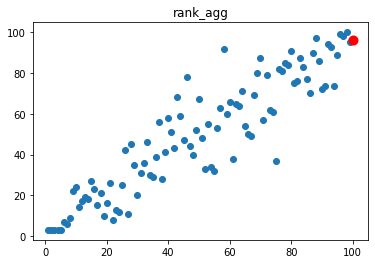

0.7520232075140735 1.6857779143995647e-28


In [23]:
rank_pca, rank_fnorm, rank_grad, rank_ntk, rank_lr, rank_flops, rank_params = \
stats.rankdata(pca_scores), stats.rankdata(fnorm_scores), stats.rankdata(grad_scores), stats.rankdata(ntk_scores), stats.rankdata(lr_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

###
# tmp = -np.abs(1.5-np.array(grad_scores))
# rank_grad = stats.rankdata(tmp)
###

l = len(api_valid_accs)
# rank_agg = rank_lr
# rank_agg = rank_params
rank_agg = np.log(rank_pca/l) + np.log(rank_fnorm/l) + np.log(rank_grad/l) + np.log(rank_params/l)
# rank_agg = np.log(rank_pca/l) + np.log(rank_fnorm/l) + np.log(rank_grad/l) + np.log(rank_params/l) + np.log(rank_ntk/l) + np.log(rank_lr/l)
# rank_agg = np.log(rank_pca/l) + np.log(rank_grad/l) + np.log(rank_ntk/l) + np.log(rank_lr/l) + np.log(rank_params/l)

best_idx = np.argmax(rank_agg)
best_arch, best_ntk_score, best_lr_score, flops, params = archs[best_idx], ntk_scores[best_idx], lr_scores[best_idx], api_flops[best_idx], api_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with ntk_score={:}, lr_score={:}".format(best_arch, best_ntk_score, best_lr_score))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
# x = np.array(lr_scores)
# plt.xlim([-1,0])
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
# target = rank_params
# plt.scatter(x[np.argmax(target)], y[np.argmax(target)], c="k", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [ ]:
sorted_indices = np.argsort(api_valid_accs)
sorted_indices = np.argsort(grad_scores)

for a, s, acc in zip(np.array(archs)[sorted_indices], np.array(grad_scores)[sorted_indices], np.array(api_valid_accs)[sorted_indices]):
    print(a)
    print("{:.3f}".format(acc), '\t', s)

In [ ]:
# fp_results = torch.load("./c3n1_1000samples.pth")
# archs = fp_results['archs']
# fp_ntk_scores = fp_results['ntk_scores']
# fp_lr_scores = fp_results['lr_scores']
# api_valid_accs = fp_results['api_valid_accs']
# api_flops = fp_results['api_flops']
# api_params = fp_results['api_params']

# torch.save({"archs":archs,
#             "ntk_scores":ntk_scores,
#             "pca_scores":pca_scores,
#             "lr_scores":lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_32_8_4_2.pth")

# torch.save({"archs":archs,
#             "fp_ntk_scores":fp_ntk_scores,
#             "fp_lr_scores":fp_lr_scores,
#             "q_ntk_scores":q_ntk_scores,
#             "q_lr_scores":q_lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_1bit.pth")

# trained_results = torch.load("./c3n5_1000samples_4bit.pth")
# archs = trained_results['archs']
# fp_ntk_scores = trained_results['fp_ntk_scores']
# fp_lr_scores = trained_results['fp_lr_scores']
# q_ntk_scores = trained_results['q_ntk_scores']
# q_lr_scores = trained_results['q_lr_scores']
# api_valid_accs = trained_results['api_valid_accs']
# api_flops = trained_results['api_flops']
# api_params = trained_results['api_params']